In [ ]:
!pip install fastai

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/MachineHack/Leaf Species Recognition/Participants_Data_cvdc2020.zip","r") as zip_ref:
    zip_ref.extractall("input")

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
import shutil
import warnings
warnings.filterwarnings("ignore")
newpath = r'/content/input/Participants_Data_cvdc2020/Train2/images' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
print(os.listdir("/content/input/Participants_Data_cvdc2020/"))
# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['Test.csv', 'Test', 'sample_submission.csv', 'Train.csv', 'Train2', 'Train', '.DS_Store']


In [ ]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

In [ ]:
data_folder = Path("/content/input/Participants_Data_cvdc2020/Train2")

In [ ]:
data_path = "/content/input/Participants_Data_cvdc2020/Train2/images"
path = os.path.join(data_path , "*jpg")

In [ ]:
# mypath = "/content/input/Participants_Data_cvdc2020/Train"
# for root, dirs, files in os.walk(mypath):
#     for file in files:
#       src = mypath+"/"+file
#       dst = "/content/input/Participants_Data_cvdc2020/Train2/images"
#       shutil.move(src, dst) 

In [ ]:
# mypath = "/content/input/Participants_Data_cvdc2020/Test"
# for root, dirs, files in os.walk(mypath):
#     for file in files:
#       src = mypath+"/"+file
#       dst = "/content/input/Participants_Data_cvdc2020/Train2/images"
#       shutil.move(src, dst)

In [ ]:
train_df = pd.read_csv('/content/input/Participants_Data_cvdc2020/Train.csv').drop("file_id",axis=1)[["file_name","species"]]
test_df = pd.read_csv('/content/input/Participants_Data_cvdc2020/Test.csv').drop("file_id",axis=1)[["file_name"]]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df["species"] = le.fit_transform(train_df["species"])

In [ ]:
train_df

,file_name,species
0,55502.jpg,0
1,55510.jpg,0
2,55515.jpg,0
3,55516.jpg,0
4,55517.jpg,0
...,...,...
10798,83814.jpg,183
10799,83815.jpg,183
10800,83818.jpg,183
10801,83819.jpg,183


In [ ]:
# train_imagesdf=[]
# for file1 in train_df["file_name"].values:
#       image = cv2.imread("/content/input/Participants_Data_cvdc2020/Train2/images"+file1)
#       train_imagesdf.append(image)
# test_imagesdf=[]
# for file1 in test_df["file_name"].values:
#       image = cv2.imread("/content/input/Participants_Data_cvdc2020/Train2/images"+file1)
#       test_imagesdf.append(image)

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)

test_img = ImageList.from_df(test_df, path=data_folder, folder='images')

In [ ]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train_df, path=data_folder, folder='images')
      #  .split_by_rand_pct(0.2)
       .split_none()
       .label_from_df()
       .add_test(test_img))

In [ ]:
data = (src.transform(tfms, size=299,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=32, device= torch.device('cuda:0')).normalize(imagenet_stats))

In [ ]:
print(data.classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184]


In [ ]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[FBeta(beta=1, average='macro'), accuracy],
                    callback_fns=ShowGraph)

epoch,train_loss,valid_loss,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 4.79E-03


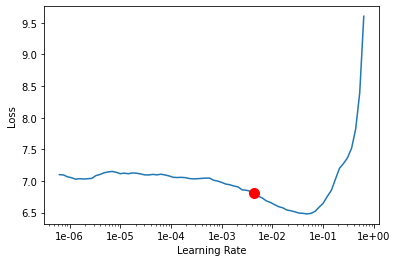

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 4e-03
learn.fit_one_cycle(15, slice(lr), wd=0.2)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,3.428453,1.900156,0.510113,0.533333,07:33
1,1.699614,1.105465,0.669410,0.684259,07:27
2,1.237549,0.790488,0.758526,0.772222,07:29
3,0.917512,0.598482,0.834538,0.837037,07:33
4,0.628465,0.464814,0.866245,0.869444,07:22
5,0.431774,0.318665,0.909317,0.908333,07:19
6,0.285106,0.283626,0.918226,0.920370,07:14
7,0.231532,0.277644,0.920383,0.921296,07:14


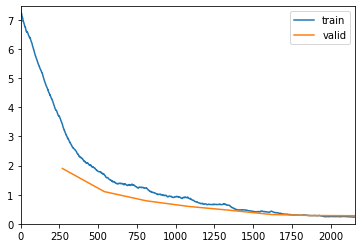

In [ ]:
# lr = 4e-03
# learn.fit_one_cycle(8, slice(lr), wd=0.2)

In [ ]:
# learn.fit_one_cycle(3, slice(lr/2), wd=0.2)

In [ ]:
learn.freeze_to(-10)

epoch,train_loss,valid_loss,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


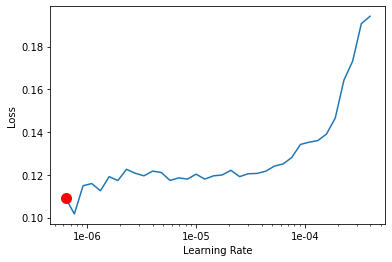

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# learn.export(file = Path("/content/drive/My Drive/Colab Notebooks/MachineHack/Leaf Species Recognition/Bestnormalexport94.pkl"))

In [ ]:
learn.fit_one_cycle(3, slice(1e-06, lr/10),wd=0.1)

In [ ]:
learn.freeze_to(-3)

epoch,train_loss,valid_loss,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 1.58E-07


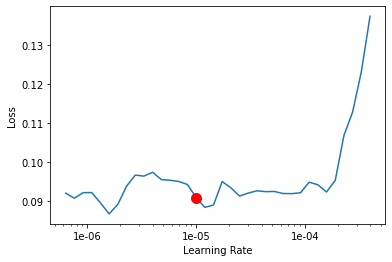

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.186533,0.269374,0.925732,0.923611,07:49
1,0.123426,0.200688,0.948211,0.947222,07:37
2,0.082385,0.168930,0.956532,0.956019,07:37


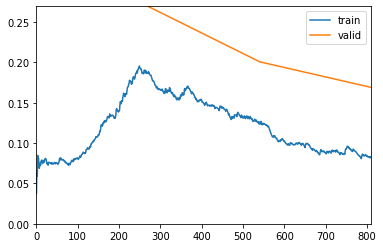

In [ ]:
learn.fit_one_cycle(3, slice(1e-05, lr/20),wd=0.2)

In [ ]:
learn.export(file = Path("/content/drive/My Drive/Colab Notebooks/MachineHack/Leaf Species Recognition/Bestexport956.pkl"))

In [ ]:
# deployed_path = "/content/drive/My Drive/Colab Notebooks/MachineHack/Leaf Species Recognition/export3.pkl"
# learn = load_learner(deployed_path)

In [ ]:
preds,_ = learn.TTA(ds_type=DatasetType.Test) # 
# preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i]) for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

In [ ]:
import pickle
with open("/content/drive/My Drive/Colab Notebooks/MachineHack/Leaf Species Recognition/best_preds3.pkl", 'wb') as f:
  pickle.dump(preds, f)
#---------------------------------------
# with open(sFilename, 'r') as fiModel:
#     preds = pickle.load(fiModel)

### Ensemble of Same model with different learning rate shown lot of improvement in LB, If we could use different models and then ensemble we can reach 99.xx

In [ ]:
sFilename = "/content/drive/My Drive/Colab Notebooks/MachineHack/Leaf Species Recognition/best_preds3.pkl"
with open(sFilename, 'rb') as fiModel:
    preds1 = pickle.load(fiModel)
sFilename = "/content/drive/My Drive/Colab Notebooks/MachineHack/Leaf Species Recognition/best_preds2.pkl"
with open(sFilename, 'rb') as fiModel:
    preds2 = pickle.load(fiModel)
final_preds = preds1*0.6 + preds2*0.4
labelled_preds = [np.argmax(final_preds[i]) for i in range(len(final_preds))]
labelled_preds = np.array(labelled_preds)

In [ ]:
df = pd.DataFrame({'file_name':test_df['file_name'], 'species':labelled_preds})
df["species"] = df["species"].astype(int)
df["species"]  = le.inverse_transform(df["species"])
df["file_name"] = df["file_name"].astype(str)

In [ ]:
df

,file_name,species
0,55497.jpg,Abies concolor
1,55498.jpg,Abies concolor
2,55499.jpg,Abies concolor
3,55500.jpg,Abies concolor
4,55501.jpg,Abies concolor
...,...,...
20058,83811.jpg,Ulmus rubra
20059,83812.jpg,Ulmus rubra
20060,83816.jpg,Ulmus rubra
20061,83817.jpg,Ulmus rubra


In [ ]:
df.to_csv("submit_cv11.csv",index=False)